Applying Dirichlet-processes to mixture-model clustering

(transformed from https://ericmjl.github.io/dl-workshop/04-gaussian-clustering/03-dirichlet-process-clustering.html )

In [15]:
import jax
from jax import numpy as jnp
from jax import random, vmap, jit, grad, lax
import optax

import matplotlib.pyplot as plt

from dp_mixgauss_truncated import component_probs_loglike, mixture_loglike, normalize_weights, animate_training

We start with a data set from a Gaussian mixture distribution with unclear number of modes.

In [16]:
# The true generative distribution
weights_true = jnp.array([2, 10, 1, 6])
locs_true = jnp.array([-2.0, -5.0, 3.0, 8.0])
scale_true = jnp.array([1.1, 2.0, 1.0, 1.5])

base_n_draws = 1000
key = random.PRNGKey(42)
keys = random.split(key, 4)

In [17]:
# Sampling from the mixture distribution
draws = []
for i in range(4):
    shape = (int(base_n_draws * weights_true[i]),)
    draw = scale_true[i] * random.normal(keys[i], shape=shape) + locs_true[i]
    draws.append(draw)
data_mixture = jnp.concatenate(draws)

When samples are from the 1-d space, we can roughly read the number of components in the mixture distribution from the histogram of the samples:

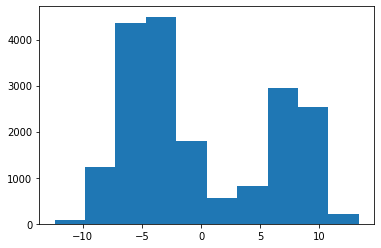

In [18]:
_ = plt.hist(data_mixture)

However, even in the 1-d space, it is not always obvious to read the number of modes in a mixture distribution from the histogram. The information starts blurring as we increase the number of bins in the histogram.

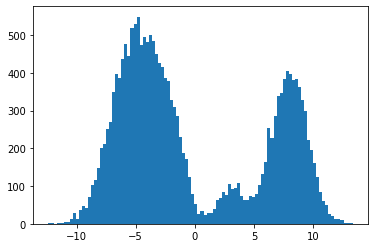

In [19]:
_ = plt.hist(data_mixture, bins=100)

Where the number of clusters is not clear, we can turn to DP mixture models, which does not impose an exact number of clusters, but controls the number of clusters probabilistically with a single concentration parameter.

Here we fit a DP Gaussian mixture model (DP-GMM) to above data and learn 
1. the concentration parameter of the DP,
2. the optimal relative weighting of components, conditioned on concentration parameters, and
3. distribution paraemters for each component, conditioned on the data.

We define the Bayesian model and try to obtain the maxinum a posterior (MAP) estimation of the these parameters. This is equivalent to miaximize the joint likelihood of these parameters and the data. Since we do not assign a prior distribution for the concentration parameter of the DP, the estimation of the concentration parameter can be seen as an empirical Bayesian approach.

In [20]:
# Defining the joint likelihood
def joint_loglike(log_component_weights, log_concentration, num_components, component_mus, log_component_scales, data):
    probs_ll = component_probs_loglike(log_component_weights, log_concentration, num_components)
    mix_ll = mixture_loglike(log_component_weights, component_mus, log_component_scales, data)
    return probs_ll + mix_ll

In [21]:
# Difining the loss function
def make_joint_loss(num_components):
    def inner(params, data):
        log_component_weights = params["log_component_weight"]
        log_concentration = params["log_concentration"]
        component_mus = params["component_mus"]
        log_component_scales = params["log_component_scale"]
        ll = joint_loglike(
            log_component_weights, log_concentration, num_components, component_mus, log_component_scales, data
        )
        return -ll

    return inner

In [22]:
# Defining the gradient descent loop
def fit(loss, optimizer, data, initial_params, T=1000):
    def step(carry, _):
        params, opt_state = carry
        loss_value, grads = jax.value_and_grad(loss)(params, data)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return (params, opt_state), (params, loss_value)

    carry = (initial_params, optimizer.init(initial_params))
    final_params, (params_history, loss_history) = lax.scan(step, carry, xs=None, length=T)
    return params_history, loss_history

In [24]:
# Initialization
k1, k2, k3, k4 = random.split(key, 4)
n_components = 50

log_component_weights_init = random.normal(k1, shape=(n_components,))
log_concentration_init = random.normal(k2, shape=(1,))
component_mus_init = random.normal(k3, shape=(n_components,))
log_component_scales_init = random.normal(k4, shape=(n_components,))

initial_params = {
    "log_component_weight": log_component_weights_init,
    "log_concentration": log_concentration_init,
    "component_mus": component_mus_init,
    "log_component_scale": log_component_scales_init,
}
loss = jit(make_joint_loss(num_components=25))
optimizer = optax.adam(learning_rate=0.05)
log_concentration_init = random.normal(key, (1,))
data = data_mixture

In [25]:
# Model fitting
params_history, loss_history = fit(loss, optimizer, data, initial_params, T=10_000)

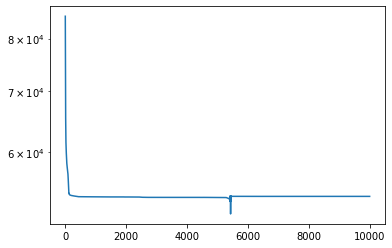

In [27]:
# Plotting the loss during the fitting process
plt.plot(loss_history)
plt.yscale("log")

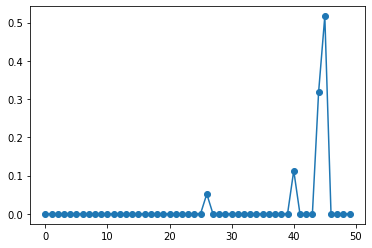

In [28]:
# Plotting the relative weights of each component
# It can be seen that the DP mixture model correctly selects 4 components out of 50.
opt_component_weights = jnp.exp(params_history["log_component_weight"][-1])
plt.plot(normalize_weights(opt_component_weights), marker="o")

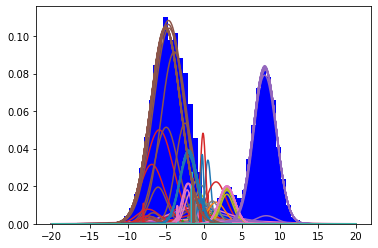

In [29]:
animation = animate_training(params_history, 500, data_mixture)